In [1]:
import agentpy as ap

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import IPython
import random as rand

matplotlib.rcParams['animation.embed_limit'] = 2**128

In [2]:
class InfectionModel(ap.Model):
    def setup(self):
        #create agents (Persons)
        nPersons = int(self.p['Population Density'] * (self.p.size**2))
        persons = self.agents = ap.AgentList(self, nPersons)
        
        #create grid (local area)
        self.city = ap.Grid(self, [self.p.size]*2, track_empty=True)
        self.city.add_agents(persons, random=True, empty=True)
        
        #Dynamic variable for all persons
        # Condition {0: Susceptible, 1: recently infected, 2: infected, 3: recovered, 4: vaccinated}
        self.agents.condition = 0
        
        #Set patient(s) zero
        self.agents.random(self.p['Initial Infected']).condition = 1
        
        #Set initial time step
        self.timeStep = 0

    def update(self): 
        pop = 0
        for i in range(0,5):
            pop += len(self.agents.select(self.agents.condition == i))
        self['S'] = len(self.agents.select(self.agents.condition == 0))/pop
        self['I'] = (len(self.agents.select(self.agents.condition == 1)) + len(self.agents.select(self.agents.condition == 2)))/pop
        self['R'] = len(self.agents.select(self.agents.condition == 3))/pop
        self['V'] = len(self.agents.select(self.agents.condition == 4))/pop #added V for Vaccinated
        self.record('S')
        self.record('I')
        self.record('R')
        self.record('V')
        
        
    def step(self):
        # select infected population
        infected_Population = self.agents.select(self.agents.condition == 1)
        infected_Population += self.agents.select(self.agents.condition == 2)
        recently_Infected = self.agents.select(self.agents.condition == 1)
        recovered_Population = self.agents.select(self.agents.condition == 3)
        
        # spread infection
        for inf in infected_Population:
            for neighbor in self.city.neighbors(inf):
                if neighbor.condition == 0:
                    if rand.uniform(0,1) < self.p['Infection Probability']:
                        neighbor.condition = 1
                        
        # move recently infected to regular infected
        for inf in recently_Infected:
            inf.condition = 2
        
        # recover infection
        for inf in infected_Population:
            if rand.uniform(0,1) < self.p['Recovery Probability']:
                inf.condition = 3
            
        # Loss of natural immunity
        for rec in recovered_Population:
            if rand.uniform(0,1) < self.p['Resusceptibility Probability']:
                rec.condition = 0
                
        #Assuming only the susceptible and recovered population can get vaccinated
        can_vaccinate = self.agents.select(self.agents.condition == 0)
        can_vaccinate += self.agents.select(self.agents.condition == 3)
        
        if self.timeStep >= self.p['Vaccination Start']:
            if len(can_vaccinate) >= self.p['Vaccination Speed']:
                can_vaccinate.random(self.p['Vaccination Speed']).condition = 4
                
        self.timeStep += 1
        
        # stop sim if no infected left
        if(len(infected_Population) == 0):
            self.stop()
        
    
    def end(self):
        
        #Document a measure at the end of the simulation
        recovered_Population = len(self.agents.select(self.agents.condition == 2))
        self.report('Percentage of recovered population', recovered_Population / len(self.agents))

In [3]:
# Define Parameterrs
parameters = {
    'Population Density':0.65,
    'size': 50,
    'steps': 500,
    'Initial Infected': 3,
    'Infection Probability': 0.3,
    'Recovery Probability': 0.1,
    'Resusceptibility Probability': 0.02,
    'Vaccination Speed': 20,
    'Vaccination Start': 200
}

Completed: 321 steps
Run time: 0:00:01.588447
Simulation finished


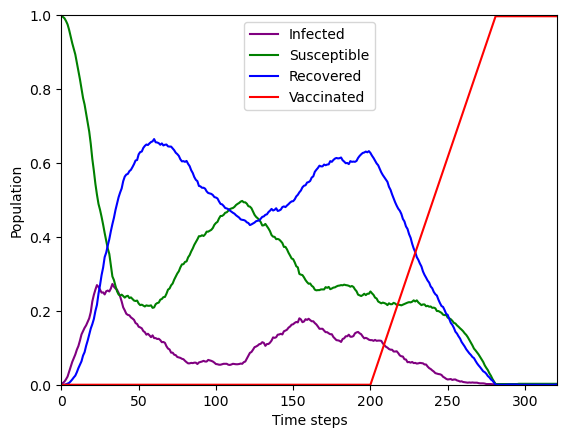

In [4]:
#Added the variable V for Vaccinated
def virus_lineplot(data, ax):
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['I', 'S', 'R', 'V']]
    
    ax.plot(x,y[0], 'purple', label = "Infected")
    ax.plot(x,y[1], 'green', label = "Susceptible")
    ax.plot(x,y[2], 'blue', label = "Recovered")
    ax.plot(x,y[3], 'red', label = 'Vaccinated')
    
    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Population")
    

model = InfectionModel(parameters)
results = model.run()
fig, ax = plt.subplots()
virus_lineplot(results.variables.InfectionModel, ax)

Completed: 287 steps
Run time: 0:00:01.525023
Simulation finished


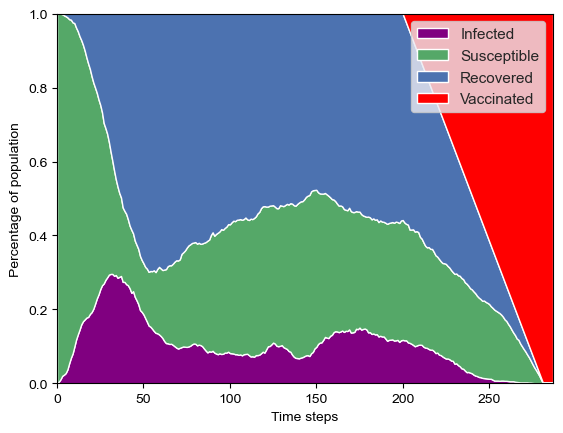

In [5]:
#Added the variable V for Vaccinated
def virus_stackplot(data, ax):
    """ Stackplot of people's condition over time. """
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['I', 'S', 'R', 'V']]

    sns.set()
    ax.stackplot(x, y, labels=['Infected', 'Susceptible', 'Recovered', 'Vaccinated'],
                 colors = ['purple', 'g', 'b', 'red'])

    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")

model = InfectionModel(parameters)
results = model.run()
fig, ax = plt.subplots()
virus_stackplot(results.variables.InfectionModel, ax)

In [6]:
# create a single-run animation

def animation_plot(model, axz):
    ax1, ax2, ax3 = axz
    attr_grid = model.city.attr_grid('condition')
    color_dict = {0:'#03c900', 1:'#f6ff00', 2:'#bd00bd', 3:'#0095ff', 4:'#Ff0000', None:'#000000'}
    ap.gridplot(attr_grid, ax=ax1, color_dict=color_dict, convert=True)
    ax1.set_title(f"Simulation of a infection\n"
                 f"Time-step: {model.t} S: ["
                 f"{len(model.agents.select(model.agents.condition == 0))}] "
                 "I: ["
                 f"{len(model.agents.select(model.agents.condition == 1))+len(model.agents.select(model.agents.condition == 2))}] "
                 "R: ["
                 f"{len(model.agents.select(model.agents.condition == 3))}]"
                 "V: ["
                 f"{len(model.agents.select(model.agents.condition == 4))}]"
                )
    
    virus_lineplot(model.output.variables.InfectionModel, ax2)
    
    virus_stackplot(model.output.variables.InfectionModel, ax3)
    

    
fig, axs = plt.subplots(1, 3, figsize=(20,6))
model = InfectionModel(parameters)
animation = ap.animate(model, fig, axs, animation_plot)

In [ ]:
# Not run for space reasons
IPython.display.HTML(animation.to_jshtml(fps=15))

In the model, the number of vaccinated people increases linearly starting from 200 as this was set as the 'Vaccination Start' in the parameters. It is not unexpected that it increased linearly, as we are adding 20 vaccinated people for every time step. As the number of vaccinated people reaches its maximum (all of the population), the number of infected, susceptible and recovered people are 0.

The simulation ends at around 300 steps for the line plot and the stack plot. The animation ends because all of the population is recovered, and there are no 'susceptible' or 'recovered' people left to be vaccinated. Since we assume that those who are vaccinated cannot get infected, as the number of vaccinated people increases, those who are infected would gradually recover and eventually get vaccinated themselves. Thus, there would eventually come a time where there are only vaccinated people in the population.

When the simulation ends, 100% of the population is vaccinated.

Now, we try to simulate the situation when we change the vaccination speed to 0 (No vaccination is performed at any time).

In [8]:
#Define New Parameters
parameters2 = {
    'Population Density':0.65,
    'size': 50,
    'steps': 500,
    'Initial Infected': 3,
    'Infection Probability': 0.3,
    'Recovery Probability': 0.1,
    'Resusceptibility Probability': 0.02,
    'Vaccination Speed': 0,
    'Vaccination Start': 200
}

Completed: 500 steps
Run time: 0:00:02.700053
Simulation finished


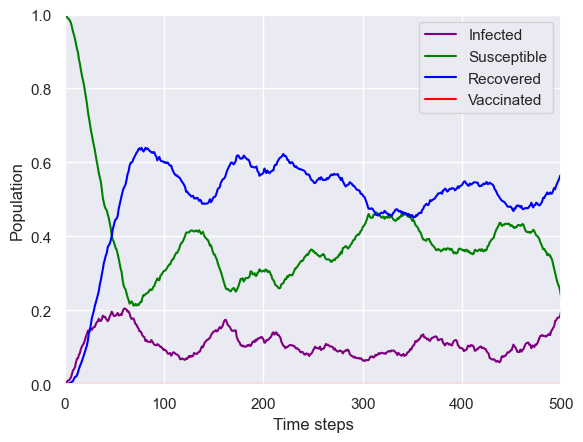

In [9]:
model = InfectionModel(parameters2)
results = model.run()
fig, ax = plt.subplots()
virus_lineplot(results.variables.InfectionModel, ax)

Completed: 500 steps
Run time: 0:00:02.738958
Simulation finished


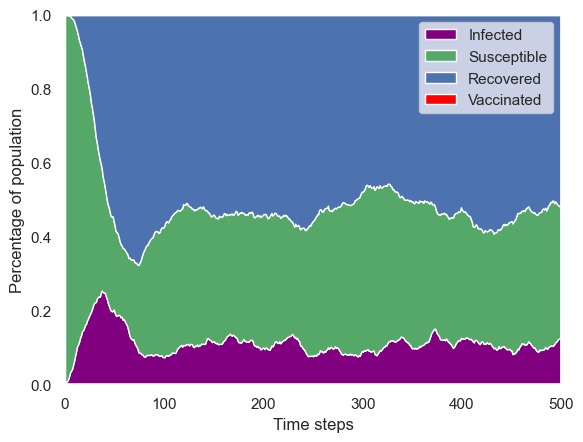

In [10]:
model = InfectionModel(parameters2)
results = model.run()
fig, ax = plt.subplots()
virus_stackplot(results.variables.InfectionModel, ax)

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(20,6))
model = InfectionModel(parameters2)
animation = ap.animate(model, fig, axs, animation_plot)

In [ ]:
# Not run for space reasons
IPython.display.HTML(animation.to_jshtml(fps=15))

As expected, as there are no attempts of vaccinations done at any time, the number of vaccinated people remains constantly at 0. Fortunately as well, there are constantly more recovered people than susceptible and infected.

Compared to the simulation with a vaccination speed of 20, this does not end because the whole population is vaccinated. In fact, none of the 3 conditions (infected, susceptible, recovered) took over 100% of the population. This means that without a vaccine, there would constantly be people who are infected with the virus, unlike the situation where the entire population was vaccinated (and therefore, never infected again) in the first simulation.

The second simulation also ended at a later time stamp compared to the first simulation. This one ended at 500 steps, compared to the 300 of the first one. This proves that the introduction of a vaccine will definitely aid in ending the breakout of a virus or a pandemic faster than simply having no vaccine. 